# Gravitational Instabilities Below Continental Crust

We consider lithospheric mantle and/or lower crust which is more dense than the asthenosphere. This density contrast drives viscous flow, though the way in which this dense material sinks is highly dependent in the middle crustal rheology, relative to the rheology of the denes material.

This notebook reproduces the primary model setup from *'Dripping or delamination? A range of mechanisms for removing the lower crust or lithosphere'* (2017) by Beall, Moresi and Stern in Geophysical Journal International.

Our aim is to quantify the dynamic contrasts between a variety of instability mechanisms:

**Dripping / Rayleigh-Taylor Instability (RTI)**

Non-linear instability which grows by the thickening and thinning of the anomalous dense material. A change in thickness introduces deviatoric normal stresses at the lithospere-asthenosphere boundary, driving viscous flow and subsequently further thickening / thinning. The sinking velocity increases exponentially and later super-exponentially with time.

<img src="img/model_Lc_0.30_Etac_1.00e+00_D_0.00_timestep_40.png" alt="delamination" style="width: 500px;"/>


**RTI 'triggered' by a high amplitude perturbation**


If a large perturbation to the lithopshere-asthenosphere interface is rapidly imposed, the subsequent dynamics differ to the classical RTI. The initial velocity is quicker and the rate at which the velocity grows is slightly higher. The morphology can also differ significantly from the classical RTI.

<img src="img/model_Lc_0.30_Etac_1.00e-01_D_0.75_timestep_70.png" alt="delamination" style="width: 500px;"/>

**Delamination**

Delamination involves the peeling away of the dense material from the continental crust above. We will choose the definition that a delaminating body is able to accellerate with negligible shear-strain. In this case, deformation of the peeling material behaves like a bending sheet. These models can to characterise how the sinking velocity of a delaminating body evolves, including the confirmation that the velocity initially increases exponentially.


<img src="img/model_Lc_1.00e-02_D_1.00_timestep_50.png" alt="delamination" style="width: 500px;"/>


In [1]:
import underworld as uw
import numpy
import glucifer
import matplotlib.pyplot as plt
import mpi4py
import h5py
from matplotlib.lines import Line2D
from scipy.stats import linregress

uw.matplotlib_inline()

comm = mpi4py.MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [2]:
outputPath = 'dripping_or_delamination_output/'

# Make output directory if necessary.
if uw.rank()==0:
    import os
    for outPath in [outputPath, outputPath + 'data/']:
        if not os.path.exists(outPath):
            os.makedirs(outPath)

## Start writing log
if rank==0:
    import time as timekeeper
    tStart = timekeeper.time()
    fw = open("Log.txt","w")
    fw.write("%s \n" %(timekeeper.ctime()))
    fw.write("Running on %i proc(s). \n" %size)
    fw.close()


Model resolution, domain and layer thicknesses. These don't need to be changed.

The paper uses an upper crustal thickness of 0.3, but its viscosity is high enough that it can be approximated by an upper no-slip BC, to make the solve quicker here.

In [3]:
# Resolution
resY = 32
resX = int(resY * 1.5)

# Set upper crust and decollement thicknesses
#      (proportionally to the dense material thickness)

# Thickness of the dense material
L = 1.0
# Thickness of decollement layer
Mlcrust = 0.3
# Thickness of upper crust.
#     If set to zero, the upper BC will be set to no-slip,
#     representing an infinitely strong upper crust.
Mcrust = 0.

M = Mlcrust + Mcrust


# Set up model domain (width 9, height 6), setting the top and base of the dense material
# as y = 0 and y=-1 respetively
minX=0.0
maxX=9.0
minY=-6. + M
maxY=0 + M


**These are the important variables that can be modified to trigger the different mechanisms.**

``D`` is the non-dimensional size of the step perturbation, in addition to a small sinusoidal perturbation which is always implemented. D is scaled as a proportion to the thickness of the dense body ``D=1`` results in the initial thinning of the entire dense material, while ``D=0`` gives no finite perturbation. ``D=1`` is required for delamination and ``D=0`` for the traditional RTI model.

``etaLc`` is the non-dimensional viscosity of the decollement layer, scaled in proportion to the dense material. ``etaLc = 1e-2`` gives a decollement layer which is 2 orders of magnitude weaker than the dense material and will trigger delamination assuming that ``D=1``. ``etaLc = 1`` gives a decollement layer which has the same viscosity of the dense material and delamination will not occur, even if ``D=1``.


In [4]:
D = 1.
etaLc = 1e-2

Set up the small initial sinusoidal perturbations

In [5]:
def InterfaceY(x,arrN,arrA,D):
    if x > 0.5*(maxX-minX):
        thinned = True
    else:
        thinned = False
    
    pertX = 0.
    if not thinned or D < 1:
        for i in range(len(arrN)):
            pertX += arrA[i] * numpy.cos(2.*numpy.pi * arrN[i] / (maxX-minX) * x )

    interface = maxY - L*(M+1.) + pertX

    if thinned:
        interface += D*L
    
    if interface > maxY - M*L:
        interface = maxY - M*L
    
    return interface
        

Set up the mesh and fields

In [6]:

elementType = "Q1/dQ0"
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (resX, resY), 
                                 minCoord    = (minX, minY), 
                                 maxCoord    = (maxX, maxY)) 



pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
velocityField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )
smoothVelField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )



Set up boundary conditions

In [7]:
IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
BottomWall = mesh.specialSets["MinJ_VertexSet"] 
TopWall = mesh.specialSets["MaxJ_VertexSet"] 
LeftWall = mesh.specialSets["MinI_VertexSet"] 
RightWall = mesh.specialSets["MaxI_VertexSet"] 

if Mcrust == 0.:
    # Noslip top
    freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              indexSetsPerDof=(IWalls+TopWall,JWalls) )
else:
    # Freeslip top
    freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              indexSetsPerDof=(IWalls,JWalls) )

Set up a swarm to track the materials (``mSwarm``), a swarm to track the dense material shear-strain (``vSwarm``), a swarm to track the decollement flow (``decolSwarm``) and a swarm to track displacement of the dense material-asthenosphere interface (``interfaceSwarm``).

In [8]:
mSwarm = uw.swarm.Swarm( mesh=mesh)
vSwarm = uw.swarm.Swarm( mesh=mesh)
DBSwarm = uw.swarm.Swarm( mesh=mesh)
decolSwarm = uw.swarm.Swarm( mesh=mesh)
interfaceSwarm = uw.swarm.Swarm( mesh=mesh)


nParticles = 12
layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=mSwarm, particlesPerCell=nParticles )

for xp in numpy.linspace(0.,0.5*maxX,12):
    for yp in numpy.linspace(maxY-1-(Mcrust+Mlcrust),maxY-(Mcrust+Mlcrust),4):
        vSwarm.add_particles_with_coordinates(numpy.array([[xp,yp]]))
        
for xp in numpy.linspace(0.,0.5*maxX,10):
    for yp in numpy.linspace(maxY-(Mcrust+Mlcrust),maxY-(Mcrust),20):
        decolSwarm.add_particles_with_coordinates(numpy.array([[xp,yp]]))

mIVar = mSwarm.add_variable( dataType="int", count=1)
vecA = vSwarm.add_variable( dataType='double',count=2)
vecB = vSwarm.add_variable( dataType='double',count=2)

mSwarm.populate_using_layout( layout=layout )

vecA.data[:,0] = 1.
vecA.data[:,1] = 0.
vecB.data[:,0] = 0.
vecB.data[:,1] = 1.


Set up the layer properties. By default, the dense material is 3 orders of magnitude stronger than the asthenosphere. The decollement layer has the same density as the asthenosphere, so that it does not contribute to the driving buoyancy of the system. If there is an upper crust (Mcrust > 0), then it 15 times more positively buoyant than the dense material is negatively buoyant.

Everything is scaled to the properties of the dense material. Its thickness, viscosity and its density contrast in comparison to the asthenosphere, are both set to 1. Gravity will also be set to 1. This means the results are non-dimensional and ready to dimensionalise to any chosen material. For example time can be dimensionalised according to: $t = t' \frac{\eta}{\Delta\rho g L}$, where the dense material viscosity ($\eta$), its anomalous density ($\Delta\rho$), its thickness ($L$) and gravity are the real-world values and $t'$ is any given time-scale in our models.

In [9]:

dRho = 1.
RhoMantle = 0.
RhoCrust =  RhoMantle - 15. * dRho
RhoLowerCrust = RhoMantle
RhoLith = RhoMantle  + dRho 

DBEta = 1.
AsthenEta = 1e-3 * DBEta
LowerCrustEta = DBEta * etaLc 
CrustEta = DBEta * 1e2

iAsthen, iDB, iCrust, iLowercrust = range(4)
dicViscosity = {iAsthen:AsthenEta, iDB:DBEta, iCrust:CrustEta, iLowercrust:LowerCrustEta}
dicDensity = {iAsthen:RhoMantle, iDB:RhoLith, iCrust:RhoCrust, iLowercrust:RhoLowerCrust}

pCoords = mSwarm.particleCoordinates





Assign the material properties to the particles (``mSwarm``). This involves choosing the initial small sinusoidal perturbation, so that the interface between the dense material and asthenosphere can be defined.

``arrN`` is an array of wavenumbers. By default there are 3 initial sinusoidal perturbations: one which fits 5 wavelengths into the model domain, one 7 and one 3.

``arrA`` is an array with the amplitude for each wave.

In [10]:
arrN = [5,7,3]
arrA = numpy.array([0.03,0.03,0.03])
for pi in range(mSwarm.particleLocalCount):
    pC = pCoords.data[pi]
    if pC[1] > maxY - Mcrust*L :
        mIVar.data[pi] = iCrust
    elif pC[1] > maxY - M*L:
        mIVar.data[pi] = iLowercrust
    elif pC[1] > InterfaceY(pC[0],arrN,arrA,D):
        mIVar.data[pi] = iDB
    else:
        mIVar.data[pi] = iAsthen

Visualise the materials that we have assigned.


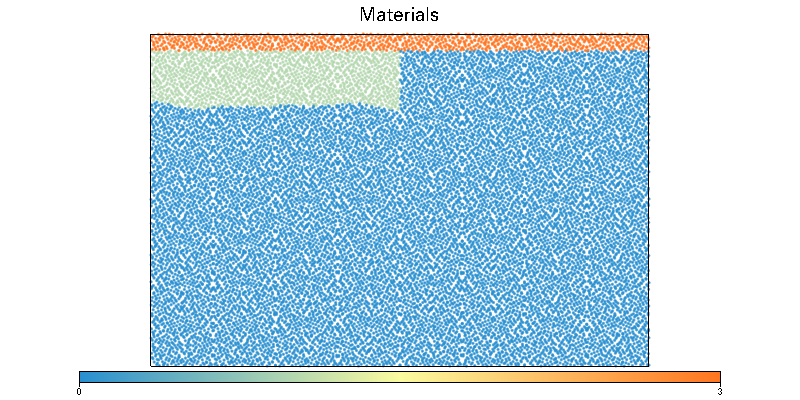

In [11]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Materials" )
figMaterial.append( glucifer.objects.Points(swarm=mSwarm,fn_colour=mIVar,fn_size=4 ))

if size == 1:
    figMaterial.show()


Put the interface marker at a point which we think will track the quickest dense material sinking velocity

In [12]:

iSwarmX = 0.485 * maxX
iSwarmY = InterfaceY(iSwarmX,arrN,arrA,D)
w0 = iSwarmY - (maxY - L*(M+1.))

interfaceSwarm.add_particles_with_coordinates(numpy.array([[iSwarmX,iSwarmY]]))
# if interfaceSwarm.particleLocalCount > 0:
#         fw = open("ParticlePosition.txt","w")
#         pX,pY = interfaceSwarm.particleCoordinates.data[0,:]
#         fw.write("%.4f \t %.4f \t %.4f \n" %(0.,pX,pY))
#         fw.close()
        


array([0], dtype=int32)

In [13]:
arrDBi = numpy.where(mIVar.data == 1)[0]
if len(arrDBi)>0:
    arrDBi = arrDBi[numpy.random.randint(0,len(arrDBi),numpy.round(0.3*len(arrDBi)))]
    DBparticles = DBSwarm.add_particles_with_coordinates(mSwarm.particleCoordinates.data[arrDBi])

Visualise where the dense material particles and interface particle are:

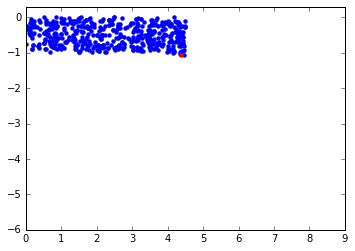

In [14]:
if rank == 0:

    plt.scatter(DBSwarm.particleCoordinates.data[:,0],DBSwarm.particleCoordinates.data[:,1],lw=0,c='blue')
    plt.scatter(interfaceSwarm.particleCoordinates.data[:,0],interfaceSwarm.particleCoordinates.data[:,1],lw=0,c='red')

    plt.gca().set_aspect('equal')
    plt.xlim(0,9)
    plt.ylim(-6,M)
    
    plt.savefig(outputPath + '/InitialDBPositions.pdf')

Assign viscosities and set up gravity and buoyancy functions

In [15]:
viscosityMapFn = uw.function.branching.map( fn_key = mIVar, 
                         mapping = dicViscosity)

densityFn = uw.function.branching.map( fn_key = mIVar, 
                         mapping = dicDensity)

gravity = ( 0.,-1.)
buoyFunc = gravity * densityFn


Visualise the viscosities


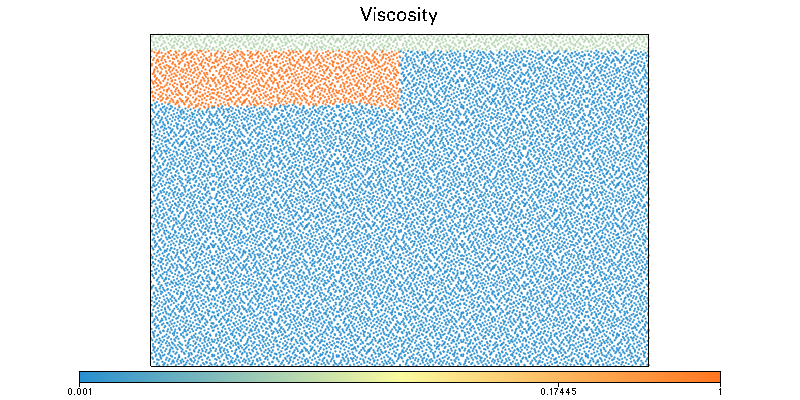

'InitialViscosity.png'

In [16]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Viscosity" )

figMaterial.append( glucifer.objects.Points(swarm=mSwarm,fn_colour=viscosityMapFn,fn_size=3,logScale=True ))



if size == 1:
    figMaterial.show()
figMaterial.save("InitialViscosity.png")

Advector objects, which will advect our particles using the velocity field solution

In [17]:

advector = uw.systems.SwarmAdvector( swarm=mSwarm, velocityField=velocityField, order=2 )
vadvector = uw.systems.SwarmAdvector( swarm=vSwarm, velocityField=velocityField, order=2 )
dadvector = uw.systems.SwarmAdvector( swarm=decolSwarm, velocityField=velocityField, order=2 )
DBadvector = uw.systems.SwarmAdvector( swarm=DBSwarm, velocityField=velocityField, order=2 )

interfaceAdvector = uw.systems.SwarmAdvector( swarm=interfaceSwarm, velocityField=velocityField, order=2 )



Stokes solver

In [18]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=viscosityMapFn, 
                              fn_bodyforce=buoyFunc,
                              voronoi_swarm=mSwarm)


solver=uw.systems.Solver(stokesPIC)
solver.options.main.Q22_pc_type='gkgdiag'


Set up functions which can save and plot data about the dense material shear-strain and decollement flow.

If running in parallel, it is best to save the needed data during the time-stepping and then plotting that data afterwards locally.

In [19]:
def plotquiver(ax,arrX,arrY,arrU,arrV):
    for i in range(len(arrX)):
        leng = 0.1
        a1 = arrX[i] - arrU[i] * leng
        a2 = arrY[i] - arrV[i] * leng
        b1 = arrX[i] + arrU[i] * leng
        b2 = arrY[i] + arrV[i] * leng

        line1 = [(a1,a2),(b1,b2)]
        (line1_xs, line1_ys) = zip(*line1)
        ax.add_line(Line2D(line1_xs, line1_ys, linewidth=1.5, color='black'))

        
def saveplotdata(step):
    vSwarm.particleCoordinates.save(outputPath + '/data/vSwarm_particleCoordinates_%i.h5' %step)
    vecA.save(outputPath + '/data/vecA_%i.h5' %step)
    vecB.save(outputPath + '/data/vecB_%i.h5' %step)
    DBSwarm.particleCoordinates.save(outputPath + '/data/mSwarm_particleCoordinates_%i.h5' %step)
    decolSwarm.particleCoordinates.save(outputPath + '/data/decolSwarm_particleCoordinates_%i.h5' %step)


def plotShearstrain(plt,step):
    if rank == 0:
        import h5py
        vecAdata = h5py.File(outputPath + '/data/vecA_%i.h5' %step)['data']
        vecBdata = h5py.File(outputPath + '/data/vecB_%i.h5' %step)['data']
        vSwarmdata = h5py.File(outputPath + '/data/vSwarm_particleCoordinates_%i.h5' %step)['data']
        mSwarmdata = h5py.File(outputPath + '/data/mSwarm_particleCoordinates_%i.h5' %step)['data']
        decolSwarmdata = h5py.File(outputPath + '/data/decolSwarm_particleCoordinates_%i.h5' %step)['data']


        plt.clf()
        ax = plt.gca()

        for i in range(len(vecAdata[:])):
            vecAdata[i] = vecAdata[i] / numpy.linalg.norm(vecAdata[i])
            vecBdata[i] = vecBdata[i] / numpy.linalg.norm(vecBdata[i])

        scale = 2.
        plotquiver(ax,vSwarmdata[:,0],vSwarmdata[:,1],vecAdata[:,0]/scale,vecAdata[:,1]/scale)
        plotquiver(ax,vSwarmdata[:,0],vSwarmdata[:,1],vecBdata[:,0]/scale,vecBdata[:,1]/scale)

        plt.scatter(mSwarmdata[:,0],mSwarmdata[:,1],lw =0,alpha=0.1,s=5. )
        plt.scatter(decolSwarmdata[:,0],decolSwarmdata[:,1],s=3.,lw=0,c="red")

        ax.set_aspect('equal')
        plt.ylim(numpy.min([-2.,1.1*numpy.min(mSwarmdata[:,1])]),maxY)


        pData = numpy.atleast_2d(numpy.loadtxt(outputPath + 'ParticlePosition.txt'))
        plt.scatter(pData[step,1],pData[step,2],c="red",lw=0,zorder=10)

        plt.xlim(0,maxX)

        plt.xlabel("Horizontal Distance (Non-Dimensional)")
        plt.ylabel("Depth (Non-Dimensional)")

        plt.savefig(outputPath + '/model_Lc_%.2f_Etac_%.2e_D_%.2f_timestep_%i.pdf' %(Mlcrust,etaLc,D,step),bbox_inches="tight")
    


For each timestep:
1. solve for velocity
2. save data
3. plot data (not generally recommended, as it slows down everything)
4. solve the integrated dense material shear-strain
5. advect particles

The number of steps to take is set to ``nSteps = 10`` by default. To properly see and measure instability accelleration, this should be changed to at least 50 and the resolution increased if possible.

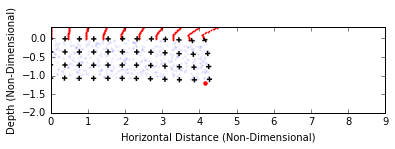

In [20]:
if rank==0:
    fw = open("Log.txt","a")
    fw.write("Setup time: %.2f seconds\n" %(timekeeper.time() - tStart))
    fw.write("--------------------- \n")
    fw.write("Time \t Step \t Stopwatch\n")
    tStart = timekeeper.time()
    fw.close()
    

# Stepping. Initialise time and timestep.
time = 0.
step = 0.
nSteps = 10

# Perform 3 steps
pLoc = [iSwarmX,iSwarmY]

# Clear ParticlePosition.txt
if rank == 0:
    if os.path.exists(outputPath + "ParticlePosition.txt"):
        os.remove(outputPath + "ParticlePosition.txt")

while step < nSteps + 1:
    # SOLVE ------------
    solver.solve()

    if interfaceSwarm.particleLocalCount > 0:
        fw = open(outputPath + "ParticlePosition.txt","a")
        pX,pY = interfaceSwarm.particleCoordinates.data[0,:]
        vY = velocityField.evaluate(numpy.array([[pX,pY]]))[0,1]
        fw.write("%.4f \t %.4f \t %.4f \t %.4e \n" %(time,pX,pY,vY))
        fw.close()
        
    if rank==0:
        fw = open("Log.txt","a")
        fw.write("%.2f \t %i \t %.2f \n" %(time,step,timekeeper.time() - tStart))
        tStart = timekeeper.time()
        fw.close()

    if step % 10 == 0:
        saveplotdata(step)

        # Run this line at a later time, if you care about performance
        plotShearstrain(plt,step)
   
    
    cF = 0.5
    dt = advector.get_max_dt()*cF

    advector.integrate(dt)
    vadvector.integrate(dt)
    interfaceAdvector.integrate(dt)
    dadvector.integrate(dt)
    DBadvector.integrate(dt)

    for i in range(vSwarm.particleLocalCount):

        lc = vSwarm.particleCoordinates.data[i]
        velG = velocityField.fn_gradient.evaluate([lc[0],lc[1]])[0]
        mvelG = numpy.matrix( [ [velG[0],velG[1]],[velG[2],velG[3]]])

        vecA.data[i] =  ((mvelG*dt + numpy.eye(2)) * numpy.matrix(vecA.data[i]).T ).T
        vecB.data[i] =  ((mvelG*dt + numpy.eye(2)) * numpy.matrix(vecB.data[i]).T ).T
            

    
    
    time += dt
    step += 1



Plot the marker displacement and velcoity over time. They should both increase exponentially.
The growth-rate can be apprxoimately measured by plotting log(displacement) and/or log(velocity) against time and measuring the slope.

Alternatively, you can pick a reference displacement and compare the time it takes to reach that displacement, for different mechanisms.

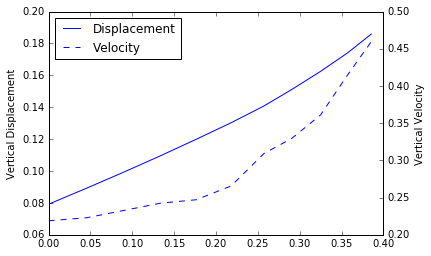

In [21]:
if rank == 0:
    data = numpy.loadtxt(outputPath + 'ParticlePosition.txt')
    
    plt.clf()

    pA = plt.gca().plot(data[:,0], (-1. * data[:,2] - 1.),label="Displacement")
    plt.ylabel("Vertical Displacement")
    
    ax2 = plt.gca().twinx()
    pB = ax2.plot(data[:,0],-1. * data[:,3],"--",label="Velocity")
    ax2.set_ylabel("Vertical Velocity")

    plt.xlabel("Time")
    lns = pA + pB
    labs = [l.get_label() for l in lns]
    
    plt.legend(lns,labs,loc=2)
    plt.savefig(outputPath + "DisplacementVelocity.pdf")

